# Retail - Predict factory order quantities for new products

Author: Andrea Kropp
Version date: April 2023

## Summary

### Business Context

The following notebook is designed for retail organizations (especially luxury brands), specifically for their data scientists and business leaders who are responsible for new product launches.

Retailers face many decisions when launching new products. One key decision is __the amount of product to order from the manufacturer.__ Ordering too much of a product is a waste of working capital and can lead to products being heavily discounted. Ordering too little squanders an opportunity for revenue and may cause customers to purchase other brands. Getting initial orders quantities right is particularly difficult for luxury products where first year demand for a new purse, a new belt, or a new shoe can vary by several orders of magnitude based on factors unrelated to the product specifications.

Faced with this reality, internal buyers responsible for placing initial factory orders often use rules of thumb or aggregate guesses amongst themselves to decide whether to produce 1,000, 10,000, 100,000, or 1 million units. AI systems may be capable of providing a __better prediction of demand__ in such situations.

### Scenario and use case

This notebooks demonstrates the role of Adidas deciding how many units of a new shoe should be ordered from their factory to support the first year of sales. This decision must be made six months prior to the intended launch date. At that point in time, Adidas know a lot about the shoe, such as the colors and materials, but there is no final product image. 

An important part of this use case is using only the features which would be known at the time the order must be placed. While some of the features are 100% known, others are better thought of as "planned". An example is the launch month. In addition to estimating initial order volumes, the model created below can be also be used for basic scenario planning to estimate the impact of the launch month on sales of the shoe.

### Notebook contents

The notebook covers basic exploratory data analysis, running machine learning experiments in DataRobot and reviewing the results of those experiments to extract business insights and evaluate model accuracy.

The notebook ends with applying the model to the full dataset to see where it makes the most errors. It turns out that the model makes the largest errors when predicting the Yeezy brand. This insight would typically lead a data scientist to develop a separate model for Yeezy-brand shoes and non-Yeezy-brand shoes to improve accuracy for both segments. This step is not shown, but would be the same as the original model development using subsets of the data.

### Data attribtion

This is not true Adidas primary sales data. The data used in this demonstration was obtained by DataRobot staff using the StockX API. [StockX](https://stockx.com/) is a global marketplace for buying and selling "the world's most coveted items". Adidas shoe images, descriptions and sales data were obtained from StockX to build this notebook. DataRobot then created additional features not provided by StockX by applying natural language processing to the description text.

#### Note on data quality

Note that the provided dataset is for demonstration purposes only and contains acute data quality issues. For example, StockX does not provide a list of colors, so DataRobot sampled pixels from the photograph to generate a list of colors. Due to the white background in the photographs, even all black shoes will have white listed as a color. To simulate the concept image sketch which would be available at the time of factory order, DataRobot staff applied a filter to the final photograph to produce a less detailed, greyscale image.

## Setup

### Import libraries

The first cell of the notebook imports necessary packages, and sets up the connection to the DataRobot platform. 

In [1]:
import base64
import io
from io import BytesIO, StringIO
import random
import time

from IPython.display import display
from PIL import Image
import datarobot as dr
from datarobot.models.visualai import ImageActivationMap, ImageEmbedding, SampleImage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Define custom functions

This workflow involves image manipulation which requires this custom function.

In [2]:
def convert_str_to_img(img_str):
    b = base64.b64decode(img_str)
    b64 = BytesIO(b)
    b64.seek(0)
    return Image.open(b64)

### Define chart parameters

These parameters are used later in the notebook to control the look and feel of figures. 

In [3]:
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["figure.titlesize"] = 24

dr_dark_blue = "#08233F"
dr_blue = "#1F77B4"
dr_orange = "#FF7F0E"
dr_red = "#BE3C28"
dr_light_blue = "#3CA3E8"

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the Python client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [4]:
api_key = ""  # Get this from the Developer Tools page in the DataRobot UI
endpoint = "https://app.datarobot.com/"  # This should be the URL you use to access the DataRobot UI

dr.Client(endpoint="%sapi/v2" % (endpoint), token=api_key)

## Access and import data

The data for this use case is provided as a ZIP file in DataRobot's public datasets area on Amazon S3. You can download the ZIP file [here](https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/shoes_demo_final.zip).

The ZIP file contains a CSV file with approximatley 1000 rows. This file contains all the numeric, categorical, and text data for the use case. Inside the ZIP file there are two subfolders named productImage and conceptImage which contain the images that belong to this use case.

The DataRobot documentation explains how to prepare your files when using images. Be sure to [follow these guidelines](https://app.datarobot.com/docs/modeling/special-workflows/visual-ai/vai-model.html#prepare-the-dataset) for prepaing your images and CSV file. 

Use the following cells to import data into DataRobot.

In [5]:
# Option 1: Single step dataset upload. This may not work for all users.
dataset = dr.Dataset.upload(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/shoes_demo_final.zip"
)

In [6]:
# Option 2: Two step dataset upload. First download the zip file to your local system. Then upload it to DataRobot.

# Visit https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/shoes_demo_final.zip to download file
# dataset = dr.Dataset.create_from_file(file_path='[UPDATE WITH CORRECT PATH HERE]/shoes_demo_final.zip')

In [7]:
# Print the unique identifier for the dataset in AI Catalog
data_id = dataset.id
data_id

'6441ce71a12385eecb595586'

## Explore the data

In this section, familairize yourself with the data and consider a few different ways to structure the prediction problem. Begin by accessing the dataset that has been uploaded to the AI Catalog and converting it to a pandas dataframe so that you can use familiar libraries for summarizing and plotting data.

__Every row in the data set is a different shoe.__

### Retrieve and view dataset

In [8]:
# Retrieve the dataset and convert it to a pandas dataframe
df = dr.Dataset.get(data_id).get_as_dataframe()
df.head()

,uuID,releaseDate,conceptDate,title,franchise,model,description,age,primary_material,collaborator,retailPrice,annual_sales,log_annual_sales,releaseMonth,releaseQtr,colors_general,color_specific,productPhoto,conceptImage
0,0010ee03-fde3-496e-a3e1-72f2311c3be2,1/15/22,7/19/21,adidas Harden Vol. 6 Black White,Harden,adidas Harden Vol. 6,NaN,Adults,Standard,James Harden,150,6227,3.8,Jan,Q1,"['black', 'gray', 'silver', 'white']","['darkgray', 'darkslategray', 'gainsboro', 'gr...",iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAIAAACVT/22AA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAIAAACVT/22AA...
1,00945770-349a-44fc-8ac9-35102c8b3488,9/19/19,3/23/19,adidas Yeezy Boost 350 V2 Cloud White (Reflect...,Yeezy,adidas Yeezy Boost 350 V2,The adidas Yeezy Boost 350 V2 Cloud White (Ref...,Adults,Primeknit,Kanye West,220,3781,3.6,Sep,Q3,"['silver', 'white']","['darkgray', 'gainsboro', 'lightgray', 'silver...",iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAIAAACVT/22AA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAIAAACVT/22AA...
2,01847d3c-ebbf-4156-9285-2219ceda3812,3/9/22,9/10/21,adidas Ultra Boost Climacool 2 DNA Flow Pack B...,Ultra Boost,adidas Ultra Boost Climacool 2 DNA,NaN,Adults,Standard,None/Other,190,1469,3.2,Mar,Q1,"['black', 'gray', 'silver', 'white']","['darkgray', 'darkslategray', 'gainsboro', 'gr...",iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAIAAACVT/22AA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAIAAACVT/22AA...
3,01ee5615-3df7-4e5b-987c-9647a50dc75b,2/1/21,8/5/20,adidas Ultra Boost 4.0 DNA Cloud White (W),Ultra Boost,adidas Ultra Boost 4.0 DNA,NaN,Adults,Standard,None/Other,180,3475,3.5,Feb,Q1,"['gray', 'silver', 'white']","['darkgray', 'dimgray', 'gainsboro', 'gray', '...",iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAIAAACVT/22AA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAIAAACVT/22AA...
4,0223e5a4-f4a5-4a72-a84c-bf9632fea501,5/27/22,11/28/21,adidas Super Sleek 3 Strap Ivy Park Wonder Whi...,Super Sleek,adidas Super Sleek 3 Strap,NaN,Adults,Standard,Beyonce Ivy Park,120,2521,3.4,May,Q2,"['gray', 'olive', 'silver', 'white']","['darkgray', 'darkolivegreen', 'gainsboro', 'g...",iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAIAAACVT/22AA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAIAAACVT/22AA...


### Explore the shoes
Use the cell below to look at the variety of shoes in the data set. Enter different numbers for the random seed and re-run the cell.

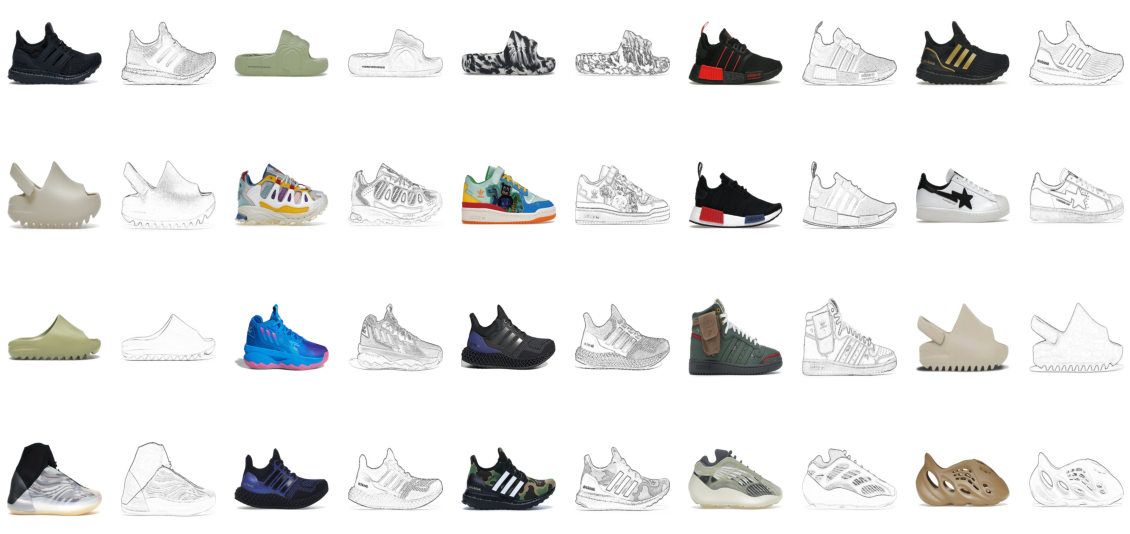

In [9]:
random.seed(104)  # Change this number to see different shoes

# Select 20 shoes and convert images for display
shoes_to_show = random.sample(range(0, len(df)), 20)

images = []
for i in shoes_to_show:
    images.append(convert_str_to_img(df.loc[i, "productPhoto"]))
    images.append(convert_str_to_img(df.loc[i, "conceptImage"]))

# Plot images in a grid
fig, axes = plt.subplots(4, int(len(shoes_to_show) / 2), figsize=(20, 10))

for img, ax in zip(images, axes.flat):
    ax.imshow(img)
    ax.axis("off")

### Explore the Structured Data

In this section you perform aggregations and apply visualizations to understand the variations present in the data. 

Text(0.5, 0, 'Retail Price')

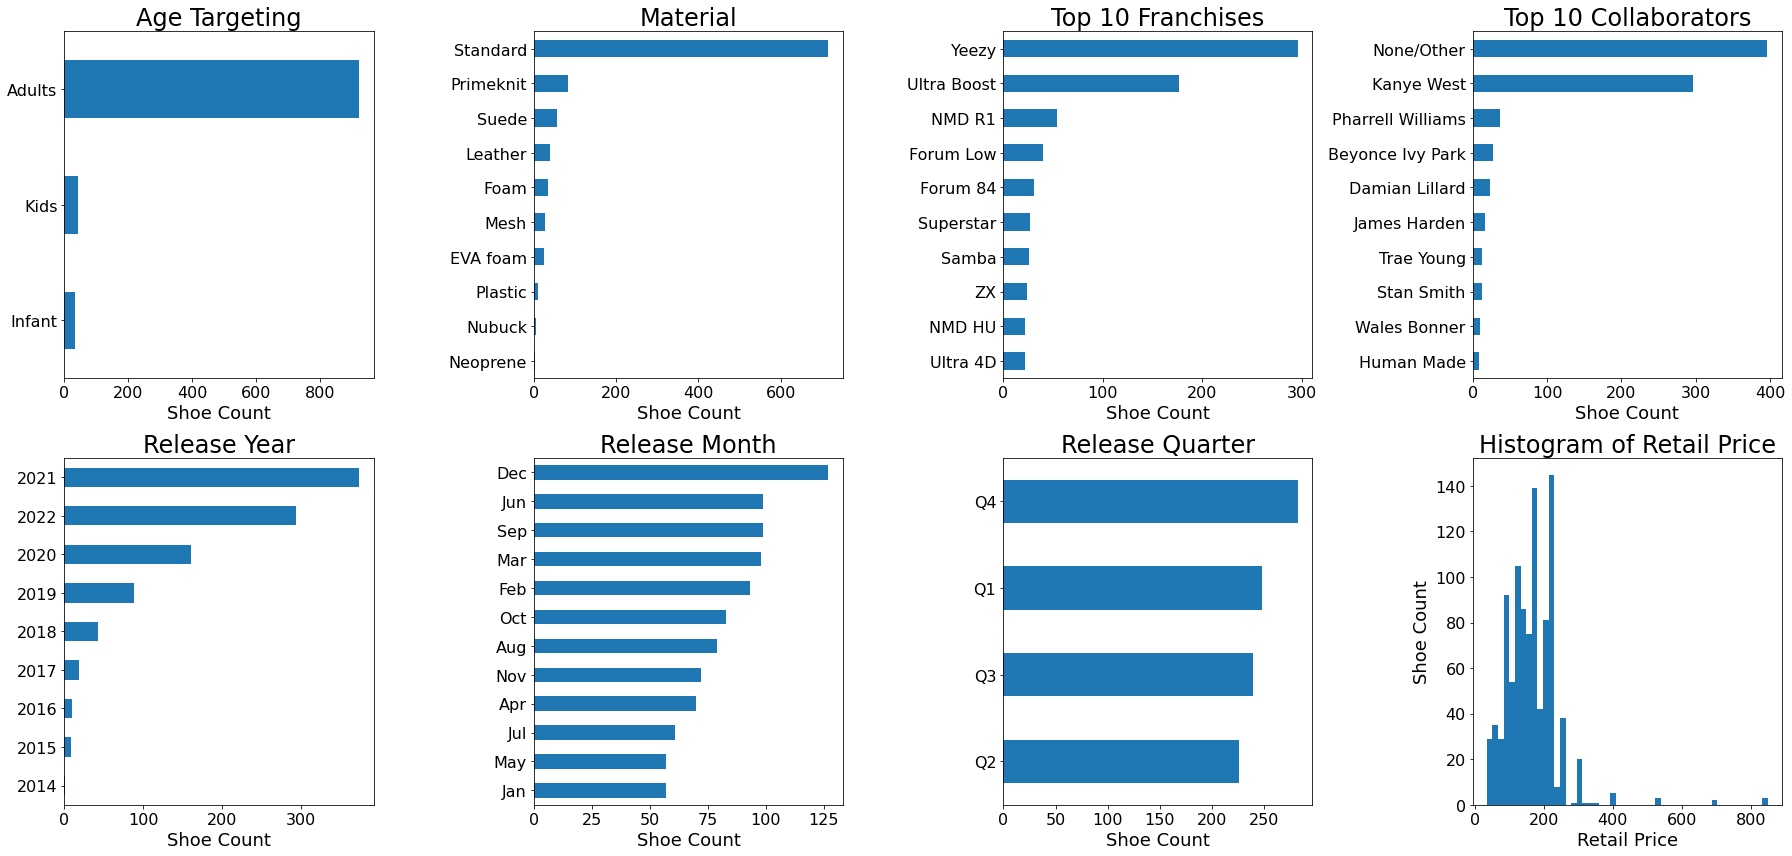

In [10]:
# Explore the structured data provided for the shoes

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 12), tight_layout=True)

plt.subplot(2, 4, 1)
df["age"].value_counts().sort_values().plot(kind="barh")
plt.title("Age Targeting")
plt.xlabel("Shoe Count")

plt.subplot(2, 4, 2)
df["primary_material"].value_counts().sort_values().plot(kind="barh")
plt.title("Material")
plt.xlabel("Shoe Count")

plt.subplot(2, 4, 3)
df["franchise"].value_counts()[0:10].sort_values().plot(kind="barh")
plt.title("Top 10 Franchises")
plt.xlabel("Shoe Count")

plt.subplot(2, 4, 4)
df["collaborator"].value_counts()[0:10].sort_values().plot(kind="barh")
plt.title("Top 10 Collaborators")
plt.xlabel("Shoe Count")

plt.subplot(2, 4, 5)
pd.to_datetime(df["releaseDate"]).dt.year.value_counts().sort_values().plot(kind="barh")
plt.title("Release Year")
plt.xlabel("Shoe Count")

plt.subplot(2, 4, 6)
df["releaseMonth"].value_counts().sort_values().plot(kind="barh")
plt.title("Release Month")
plt.xlabel("Shoe Count")

plt.subplot(2, 4, 7)
df["releaseQtr"].value_counts().sort_values().plot(kind="barh")
plt.title("Release Quarter")
plt.xlabel("Shoe Count")

plt.subplot(2, 4, 8)
plt.hist(df["retailPrice"], bins=50)
plt.title(
    "Histogram of Retail Price",
)
plt.ylabel("Shoe Count")
plt.xlabel("Retail Price")

### Explore the unstructured data

In this section you examine the semi-structured text data to understand the variation present in the data. By printing a few of the descriptions it becomes apparent that there are many missing descriptions.

In [11]:
random.seed(104)  # Change this number to see different text descriptions

descriptions_to_print = random.sample(range(0, len(df)), 5)

pd.set_option("display.max_colwidth", None)
print(df["description"][descriptions_to_print])

982                                                                                   The adidas Ultra Boost 4 Triple Black arrives in a color palette, featuring a âTriple Blackâ offering that is formed with a sock-like fit of Primeknit application on the upper.\n\nThis Ultra Boost 4 by adidas features a low-top silhouette taht is entirely adorned in the deep black shade. Texture contrasts are also prevalent throughout with matte-finished cage overlays and heel support systems in plastic instead of the nubuck material. The Continental rubber outsole is for traction, while the tonal full-length Boost midsole is for cushioning.\n
20                                                                                                                                                                                                                                                                                      As part of the adidas Originals Spring / Summer 2022 collection, the adidas Adil

### A note on sales as a proxy for demand

The focus of this use case is to predict demand in the first year in order to place an initial factory order which is the appropriate size. Most retail and CPG companies do not have a direct way to measure demand. Instead, they rely on historical sales as a proxy for demand. Historical sales are a good approximation, but do not account for:

1. Days that the product was in demand but not available. This causes sales to be lower than demand.
2. Days that competitor products were in demand but not available resulting in the purchase of your product. This causes sales to be higher than demand. This deviation is typically less problematic for modeling purposes if competitors continue to have future stock-outs similar to historical stockouts.

This use case focuses primarily on luxury products. For luxury products, sales are an excellent proxy for demand because customers are more willing to wait for the exact product they want and less likely to substitute.

### Select a target for modeling

The dataframe contains both 'annual_sales' and 'log_annual sales'. __Which is better for creating a predictive model?__ The answer depends on your business need and on the distribution of your historical sales data. The next cell plots the distribution of Annual Sales and the Log of Annual Sales to aid in making this decision.

Text(0, 0.5, 'Shoe Count')

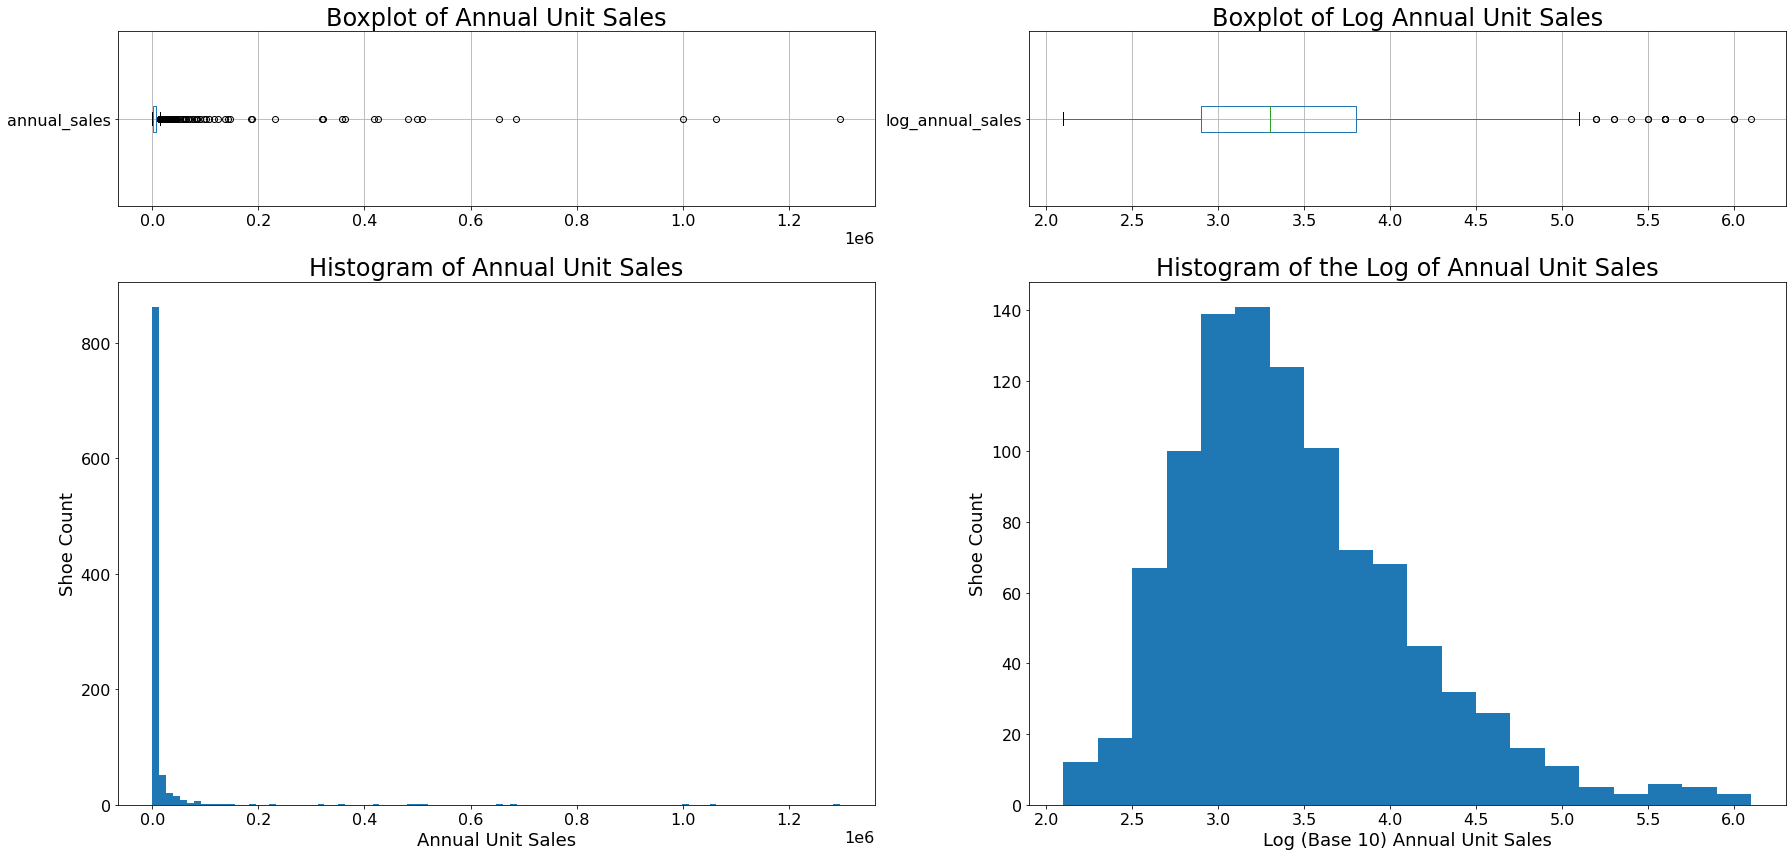

In [12]:
# Explore the sales data provided for the shoes
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    tight_layout=True,
    figsize=(25, 12),
    gridspec_kw={"height_ratios": [1, 3]},
)

plt.subplot(2, 2, 1)
df.boxplot(column="annual_sales", vert=False)
plt.title("Boxplot of Annual Unit Sales")

plt.subplot(2, 2, 2)
df.boxplot(column="log_annual_sales", vert=False)
plt.title("Boxplot of Log Annual Unit Sales")

plt.subplot(2, 2, 3)
plt.hist(df["annual_sales"], bins=100)
plt.title("Histogram of Annual Unit Sales")
plt.xlabel("Annual Unit Sales")
plt.ylabel("Shoe Count")

plt.subplot(2, 2, 4)
plt.hist(df["log_annual_sales"], bins=20)
plt.title("Histogram of the Log of Annual Unit Sales")
plt.xlabel("Log (Base 10) Annual Unit Sales")
plt.ylabel("Shoe Count")

The distribution of the `annual_sale`s (left charts) is heavily right-skewed.  The log-transformed data (right charts) is a better approximatation of a normal distribution.

DataRobot's ML experimentation does not require a normal distribution. The software will suggest an optimization metric based on the detected distribution of your target variable. It is a valid strategy to experiment with both the original sales numbers and the log transformation. 

__This notebook will use log_annual_sales as the target varible__. The primary reason is that the business question is framed as ordering the right order of magnitude of product. At the extremes, the shoes in this dataset are separated by five orders of magnitude. The best seller sold 10,000 times as well as the worst seller.

The best and worst sellers are revealed below.

In [13]:
max_sales = df["annual_sales"].max()
best_seller = df[df["annual_sales"] == df["annual_sales"].max()]["title"]
best_seller = best_seller.to_string(index=False)

min_sales = df["annual_sales"].min()
worst_seller = df[df["annual_sales"] == df["annual_sales"].min()]["title"]
worst_seller = worst_seller.to_string(index=False)

In [14]:
print(
    "The best performing shoe is the "
    + best_seller
    + " with annualized unit sales of "
    + str(max_sales)
)

The best performing shoe is the adidas Yeezy Slide Onyx with annualized unit sales of 1297431


In [15]:
print(
    "The worst performing shoe is the "
    + worst_seller
    + " with annualized unit sales of "
    + str(min_sales)
)

The worst performing shoe is the adidas Ultra Boost 1.0 Core Black (1.0) with annualized unit sales of 127


## Create a DataRobot project

Since the dataset is already in the AI Catalog, the simplest way to create a new DataRobot project is with `create_from_dataset()`.

Start a new project and obtain its ID number for future reference. If you wish, you can open the DataRobot UI and you'll see a new project listed after you execute the next cell. Additionally, you can view the results of the first round of Exploratory Data Analysis (EDA). Learn about the [insights that EDA1 returns](https://docs.datarobot.com/en/docs/data/analyze-data/eda-explained.html) in the documentation.

In [16]:
project = dr.Project.create_from_dataset(
    dataset.id, project_name="Predict New Shoe Order Quantity - Log Annual Sales"
)
project.id

'6441cf45da0dc8cbfad5bbe5'

### Feature list considerations

When a DataRobot project is created, at least two feature lists are automatically generated. One of these contains all the features provided and is named `Raw Features`. The other contains only the features that may be useful to solving the problem based on their completeness and distribtuion. Learn more about [automatically created feature lists](https://docs.datarobot.com/en/docs/modeling/build-models/build-basic/feature-lists.html#automatically-created-feature-lists) in the documentation.

For use cases where the event to be predicted is far into the future, it is important to examine the available features and think critically about whether they would be known at the time of prediction. The next two notebook cells retrieve the feature lists associated with the dataset and list all the features by name.

The third cell shows how a user can create a new feature list specificying exactly the information that would be known at the time of prediction. For this demonstration, __the conceptImage is used for modeling, but the final productPhoto is not__ since it would not be available at the time of prediction. 

Notice that in the sample workflow, you __choose to include the releaseDate__ in the features known at Concept Stage. Including the `releaseDate` means that the model will learn patterns related to release timing. The `releaseDate` feature can be used for scenario planning to test the impact of release timing on sales volumes as described in the introduction.

In [18]:
# List the existing feature lists
project.get_featurelists()

[Featurelist(Raw Features), Featurelist(Informative Features)]

In [19]:
# List all features from the Raw Features feature list
project.get_featurelists()[0].features

['uuID',
 'releaseDate',
 'conceptDate',
 'title',
 'franchise',
 'model',
 'description',
 'age',
 'primary_material',
 'collaborator',
 'retailPrice',
 'annual_sales',
 'log_annual_sales',
 'releaseMonth',
 'releaseQtr',
 'colors_general',
 'color_specific',
 'productPhoto',
 'conceptImage']

In [20]:
# Here the data scientist list by the name the features that are definitely known at prediction time
manually_typed_feature_names = [
    "releaseDate",
    "conceptDate",
    "title",
    "franchise",
    "model",
    "description",
    "age",
    "primary_material",
    "collaborator",
    "retailPrice",
    "colors_general",
    "color_specific",
    "conceptImage",
]

# Creating a new feature list
featurelist_concept_stage = project.create_featurelist(
    name="Features Known at Concept Stage", features=manually_typed_feature_names
)

featurelist_concept_stage.id

'6441cf93b0c4c40dfd595279'

### Optimization metric considerations

In the next cell, specify the name of the target, optimization metric, feature list name, and modeling mode. 

This example uses R Squared as the optimization metric. R Squared can be directly interpretted by the business as the percent of variance in demand explained by the model. Remember that you applied a log transform, so your R Squared is the percent of variance in the order of magnitude of demand explained by the model.

Access documentation on the [choice of optimization metrics](https://docs.datarobot.com/en/docs/modeling/reference/model-detail/opt-metric.html#optimization-metrics). You can query the metrics available for the target with dr.Project.get_metrics()

In [21]:
# The two advanced options will speed up the AutoPilot run
# Stop the model competition before creating blenders (also called ensemble models)
# Don't require that a model be prepared for deployment until after you examine the results

advanced_options = dr.AdvancedOptions(
    blend_best_models=False, prepare_model_for_deployment=False, seed=420
)

In [22]:
# This command starts the experimentation and is equivalent to pressing the Start button in the DataRobot UI
# Project settings cannot be changed after executing this cell.

project.analyze_and_model(
    target="log_annual_sales",
    metric="R Squared",
    mode=dr.AUTOPILOT_MODE.FULL_AUTO,
    featurelist_id=featurelist_concept_stage.id,
    advanced_options=advanced_options,
    worker_count=-1,
)  # Entering -1 uses all available workers

# Autopilot will take some time to complete
project.wait_for_autopilot()

In progress: 20, queued: 15 (waited: 0s)
In progress: 20, queued: 15 (waited: 1s)
In progress: 20, queued: 15 (waited: 2s)
In progress: 20, queued: 15 (waited: 3s)
In progress: 20, queued: 15 (waited: 4s)
In progress: 20, queued: 15 (waited: 7s)
In progress: 20, queued: 15 (waited: 11s)
In progress: 20, queued: 15 (waited: 18s)
In progress: 20, queued: 15 (waited: 31s)
In progress: 20, queued: 0 (waited: 58s)
In progress: 15, queued: 0 (waited: 88s)
In progress: 4, queued: 0 (waited: 119s)
In progress: 1, queued: 0 (waited: 150s)
In progress: 20, queued: 12 (waited: 180s)
In progress: 20, queued: 12 (waited: 211s)
In progress: 17, queued: 0 (waited: 242s)
In progress: 7, queued: 0 (waited: 273s)
In progress: 3, queued: 0 (waited: 303s)
In progress: 0, queued: 0 (waited: 334s)


## Examine and interpret the experiments

Next, retrieve the list of experiments and examine the error metrics. The goal is to __evaluate whether the model predictions at the concept stage are reliable enough for the business to use for placing initial factory orders.__ To do this, evalute the models against some custom business rules.

1. What percent of shoes are off by more than one order of magnitude?
2. What percent of shoes are off by more then 20,000 units?
3. What percent of shoes are off by more than 1 order of magnitude OR 20,000 units?

You will specify in advance that the business will accept any model for which the answer to question 3 is 10% of historical shoes or less.

### Retrieve models and errors metrics

Use the cell below to pull essential information about all the models on the Leaderboard into a pandas dataframe.

In [23]:
# This cell retrives all the models that have been created and loops through each model to retrieve the requested details

models = project.get_models()
leaderboard_models = pd.DataFrame()

for m in models:
    model_metrics = pd.DataFrame(
        [
            {
                "Model_Type": m.model_type,
                "Model_ID": m.id,
                "BlueprintID": m.blueprint_id,
                "Sample_Percent": m.sample_pct,
                "Featurelist": m.featurelist_name,
                "R Squared": m.metrics["R Squared"]["validation"],
                "R Squared_CV": m.metrics["R Squared"]["crossValidation"],
                "RMSE": m.metrics["RMSE"]["validation"],
                "RMSE_CV": m.metrics["RMSE"]["crossValidation"],
            }
        ]
    )

    leaderboard_models = leaderboard_models.append(
        model_metrics, sort=False
    ).reset_index(drop=True)

leaderboard_models.head(10)

,Model_Type,Model_ID,BlueprintID,Sample_Percent,Featurelist,R Squared,R Squared_CV,RMSE,RMSE_CV
0,eXtreme Gradient Boosted Trees Regressor with Unsupervised Learning Features,6441d0366ff72d72e31cdd61,f7441f6a3cd4b471f1344ea3fd18a729,63.92,Features Known at Concept Stage,0.70186,0.692644,0.37538,0.366262
1,Nystroem Kernel SVM Regressor,6441d0356ff72d72e31cdd52,5978d943ca43e2b704d3471bac9d3323,63.92,Features Known at Concept Stage,0.70122,0.677348,0.37578,0.37506
2,eXtreme Gradient Boosted Trees Regressor (Poisson Loss),6441d0366ff72d72e31cdd5f,d1d756faa0c542ca61dbcdd196f57241,63.92,Features Known at Concept Stage,0.70090,0.699318,0.37598,0.362238
3,eXtreme Gradient Boosted Trees Regressor,6441d0356ff72d72e31cdd5d,f833a1fef1c6bd0aa9e884b0547a5e32,63.92,Features Known at Concept Stage,0.69971,0.6885,0.37673,0.368494
4,Gradient Boosted Trees Regressor (Least-Squares Loss),6441d0356ff72d72e31cdd58,4c8395a82f5889531450a1cea273f48f,63.92,Features Known at Concept Stage,0.69968,0.691642,0.37675,0.366818
5,eXtreme Gradient Boosted Trees Regressor,6441d0366ff72d72e31cdd5e,013642e8871418b6efbd4f64921dbaab,63.92,Features Known at Concept Stage,0.69903,0.694724,0.37716,0.36507
6,eXtreme Gradient Boosted Trees Regressor,6441d0356ff72d72e31cdd51,bac87602e809cc52c135ef122bc87fd8,63.92,Features Known at Concept Stage,0.69903,0.694724,0.37716,0.36507
7,Light Gradient Boosted Trees Regressor with Early Stopping,6441d0356ff72d72e31cdd4f,c8fb9c44dd79ee217391ff221f510187,63.92,Features Known at Concept Stage,0.69220,0.692234,0.38141,0.366226
8,Support Vector Regressor (Radial Kernel),6441d0356ff72d72e31cdd5c,84b7a47ae013098d32d61bc21df06d1e,63.92,Features Known at Concept Stage,0.68596,None,0.38526,None
9,Gradient Boosted Greedy Trees Regressor (Least-Squares Loss),6441d0356ff72d72e31cdd59,e53fb281579fcc03f38249c861ef7e2a,63.92,Features Known at Concept Stage,0.66942,None,0.39527,None


In [24]:
len(leaderboard_models)

35

The cells above retrieve 35 complete and deployable machine learning pipelines in about seven minutes (when using 20 workers) complete with image and text featurization.

### Explore the validation data for the top model

Retrieve the model object for the top-performing model and examine the Feature Impact and residuals.

In [25]:
# Retrieve the model object for the top-performing model
top_model = project.get_top_model(metric="R Squared")
top_model.id

'6441d0366ff72d72e31cdd61'

#### Feature Impact

The next cell requests Feature Impact and saves the results to a dataframe. The description of the shoe is the dominant feature. The concept image contributes only about 4%. Notice that `retailPrice` has a very low impact around 2%. This is not uncommon for luxury goods making then hard to model with traditional approaches from the field of economics.

In [26]:
# Get Feature Impact
feature_impact = top_model.get_or_request_feature_impact()

# Save Feature Impact to a pandas dataframe
fi_df = pd.DataFrame(feature_impact)

fi_df

,featureName,impactNormalized,impactUnnormalized,redundantWith
0,releaseDate,1.000000,0.608668,None
1,description,0.510796,0.310905,None
2,title,0.117356,0.071431,None
3,age,0.077688,0.047286,None
4,conceptImage,0.042764,0.026029,None
5,model,0.039436,0.024003,None
6,retailPrice,0.022597,0.013754,None
7,primary_material,0.014431,0.008784,None
8,colors_general,0.005989,0.003645,None
9,collaborator,0.005344,0.003252,None


#### Residuals

In the next two cells, request the residual for each shoe in the validation fold. The validation fold has approximately 16% of all the data when using the DataRobot default settings. 20% of the data is in the locked Holdout and the remaining 64% is used to train the model.

In [27]:
residuals = top_model.get_all_residuals_charts()
print(residuals)

[ResidualChart(validation), ResidualChart(holdout), ResidualChart(crossValidation)]


In [28]:
# The column named actual in this table is the same as the project's target (log_annual_sales).
validation = residuals[0]

actual, predicted, residuals, row_num = zip(*validation.data)
validation_data = {
    "actual": actual,
    "predicted": predicted,
    "residuals": residuals,
    "row_num": row_num,
}
validation_df = pd.DataFrame(validation_data)
validation_df.head(10)

,actual,predicted,residuals,row_num
0,3.4,3.363887,-0.036113,16.0
1,2.7,3.280404,0.580404,17.0
2,3.1,3.180536,0.080536,19.0
3,2.4,2.427192,0.027192,31.0
4,2.3,2.754972,0.454972,41.0
5,2.6,2.596543,-0.003457,60.0
6,3.4,3.122077,-0.277923,65.0
7,2.8,3.350630,0.550630,75.0
8,3.3,3.231200,-0.068800,81.0
9,3.2,3.197288,-0.002712,105.0


Text(0.5, 1.04, 'Predicted Values vs. Actual Values')

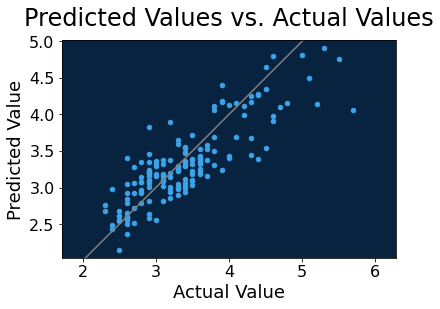

In [29]:
# Plotting the residuals is a good way to see if errors are equally distributed sometimes too high and sometimes too low
# Plot actual versus predicted for the validation slice. Add a diagonal line for perfect prediction

plot = validation_df.plot.scatter(
    x="actual",
    y="predicted",
    legend=False,
    color=dr_light_blue,
)
plot.set_facecolor(dr_dark_blue)

# Define the axes with padding
min_x = min(validation_df["actual"]) - 0.1
max_x = max(validation_df["actual"]) + 0.1
min_y = min(validation_df["predicted"]) - 0.1
max_y = max(validation_df["predicted"]) + 0.1

biggest_value = max(abs(i) for i in [min_x, max_x, min_y, max_y])

# Plot a diagonal 1:1 line to show the "perfect fit" case
diagonal = np.linspace(-biggest_value, biggest_value, 100)
plt.plot(diagonal, diagonal, color="gray")

plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.axis("equal")
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)

plt.title("Predicted Values vs. Actual Values", y=1.04)

### Evaluate if the top model meets the business requirements

Apply the custom business rules to see if the top model meets business requirements and can be deployed into production for future use.

#### Compute business-relavent metrics

Business Rule 1 checks if the order of magnitude between predicted and actual exceeds 1. On a log base 10 scale, a resdual of 1 equates to being off by a factor of 10. 

Business Rule 2 checks if the total error is more than 20,000 units.

In [30]:
validation_df["actual_units"] = round(
    10 ** validation_df["actual"], 0
)  # antilog to convert back to real units of shoes
validation_df["predicted_units"] = round(
    10 ** validation_df["predicted"], 0
)  # antilog to convert back to real units of shoes
validation_df["unit_difference"] = (
    validation_df["actual_units"] - validation_df["predicted_units"]
)

# Rule 1: Is the absolute value of the residual greater than 1?
validation_df["BizRule1"] = (
    abs(validation_df["residuals"]) > 1
)  # Creates a logical true/false variable where true is above the stated threshold

# Rule 2: Is the absolute number of units off by more than 20,000?
validation_df["BizRule2"] = abs(validation_df["unit_difference"]) > 20000

# Combined rules
validation_df["BizRuleTests"] = (
    validation_df["BizRule1"] | validation_df["BizRule2"]
)  # Uses logical OR to validate both conditions

# Percent of shoes failing the combined business tests
fail_percent_validation = round(
    sum(validation_df["BizRuleTests"]) / len(validation_df["BizRuleTests"]) * 100, 2
)
fail_percent_validation

8.12

__SUCCESS__! Less than 10% of the shoes are failing the tests. 

In [32]:
validation_df.head()

,actual,predicted,residuals,row_num,actual_units,predicted_units,unit_difference,BizRule1,BizRule2,BizRuleTests
0,3.4,3.363887,-0.036113,16.0,2512.0,2311.0,201.0,False,False,False
1,2.7,3.280404,0.580404,17.0,501.0,1907.0,-1406.0,False,False,False
2,3.1,3.180536,0.080536,19.0,1259.0,1515.0,-256.0,False,False,False
3,2.4,2.427192,0.027192,31.0,251.0,267.0,-16.0,False,False,False
4,2.3,2.754972,0.454972,41.0,200.0,569.0,-369.0,False,False,False


## Prepare the model for deployment

Next, if the business rules are satisfied for the validation data, unlock the Holdout partition. Then it runs the business rule tests again on the unseen holdout data to confirm that the model meets the business requirements.

Once everything looks satisfactory, the top model is prepared for deployment.

### Unlock holdout

In [33]:
if fail_percent_validation < 10:
    project.unlock_holdout()

In [34]:
residuals = top_model.get_all_residuals_charts()
print(residuals)

[ResidualChart(validation), ResidualChart(holdout), ResidualChart(crossValidation)]


In [35]:
# Repeat the business rules test on the unseen holdout
holdout = residuals[1]

actual, predicted, residuals, row_num = zip(*holdout.data)
holdout_data = {
    "actual": actual,
    "predicted": predicted,
    "residuals": residuals,
    "row_num": row_num,
}
holdout_df = pd.DataFrame(holdout_data)

holdout_df["actual_units"] = round(
    10 ** holdout_df["actual"], 0
)  # antilog to convert back to real units of shoes
holdout_df["predicted_units"] = round(
    10 ** holdout_df["predicted"], 0
)  # antilog to convert back to real units of shoes
holdout_df["unit_difference"] = (
    holdout_df["actual_units"] - holdout_df["predicted_units"]
)
holdout_df["BizRule1"] = (
    abs(holdout_df["residuals"]) > 1
)  # Threshold values are hard coded; be sure to update for your own use case
holdout_df["BizRule2"] = (
    abs(holdout_df["unit_difference"]) > 20000
)  # Threshold values are hard coded; be sure to update for your own use case

holdout_df["BizRuleTests"] = (
    holdout_df["BizRule1"] | holdout_df["BizRule2"]
)  # Uses logical OR to validate both conditions

fail_percent_holdout = round(
    sum(holdout_df["BizRuleTests"]) / len(holdout_df["BizRuleTests"]) * 100, 2
)
fail_percent_holdout

6.53

__Success!__

### Prepare the top model for deployment

Deployment preparation is an automated process with multiple stages as  [described in the documentation](https://docs.datarobot.com/en/docs/modeling/reference/model-detail/model-rec-process.html#prepare-a-model-for-deployment).

In [38]:
project.start_prepare_model_for_deployment(top_model.id)
project.wait_for_autopilot()

In progress: 0, queued: 0 (waited: 0s)
In progress: 0, queued: 0 (waited: 1s)
In progress: 0, queued: 0 (waited: 2s)
In progress: 0, queued: 0 (waited: 3s)
In progress: 0, queued: 0 (waited: 5s)
In progress: 0, queued: 0 (waited: 7s)
In progress: 0, queued: 0 (waited: 11s)
In progress: 0, queued: 0 (waited: 18s)
In progress: 1, queued: 0 (waited: 31s)
In progress: 1, queued: 0 (waited: 52s)
In progress: 1, queued: 0 (waited: 72s)
In progress: 1, queued: 0 (waited: 93s)
In progress: 1, queued: 0 (waited: 114s)
In progress: 1, queued: 0 (waited: 134s)
In progress: 1, queued: 0 (waited: 155s)
In progress: 1, queued: 0 (waited: 176s)
In progress: 0, queued: 0 (waited: 197s)


In [39]:
recommended_model = dr.ModelRecommendation.get_all(project.id)[0]
recommended_model

ModelRecommendation(6441cf45da0dc8cbfad5bbe5, 6441d8cfc03e4590bf155f65, Prepared for Deployment)

In [40]:
final_model = recommended_model.get_model()
final_model.id

'6441d8cfc03e4590bf155f65'

This final model is ready to be deployed. Learn more about the model by opening it in the graphical user interface.

In [41]:
final_model.open_in_browser()

### Use the final model to make predictions for the entire training data

Making predictions for all the rows in the training data using the final model is a good way to see if it is making systematic errors. As mentioned in the introduction, this model makes greater errors for Yeezy-brand shoes. It might be a good idea to split the training data into two segments if better accuracy for Yeezy shoe launches is required.

In [42]:
# Calculate new training predictions on all dataset
training_predictions_job = final_model.request_training_predictions(
    dr.enums.DATA_SUBSET.ALL
)
training_predictions = training_predictions_job.get_result_when_complete()

# Fetch training predictions as data frame
train_pred_df = training_predictions.get_all_as_dataframe()
train_pred_df["predicted_units"] = round(
    10 ** train_pred_df["prediction"], 0
)  # antilog to convert back to real units of shoes
train_pred_df.head(10)

,row_id,partition_id,prediction,predicted_units
0,0,Holdout,3.282331,1916.0
1,1,1.0,3.472328,2967.0
2,2,3.0,3.521952,3326.0
3,3,4.0,3.190459,1550.0
4,4,Holdout,3.496483,3137.0
5,5,3.0,3.975250,9446.0
6,6,2.0,3.760113,5756.0
7,7,2.0,3.882470,7629.0
8,8,4.0,3.455708,2856.0
9,9,4.0,3.152585,1421.0


In [43]:
# Joins predictions onto the original data frame used for training
df_done = train_pred_df.join(df)
df_done.head(3)

row_id partition_id  prediction  predicted_units  \
0       0      Holdout    3.282331           1916.0   
1       1          1.0    3.472328           2967.0   
2       2          3.0    3.521952           3326.0   

                                   uuID releaseDate conceptDate  \
0  0010ee03-fde3-496e-a3e1-72f2311c3be2     1/15/22     7/19/21   
1  00945770-349a-44fc-8ac9-35102c8b3488     9/19/19     3/23/19   
2  01847d3c-ebbf-4156-9285-2219ceda3812      3/9/22     9/10/21   

                                                title    franchise  \
0                    adidas Harden Vol. 6 Black White       Harden   
1  adidas Yeezy Boost 350 V2 Cloud White (Reflective)        Yeezy   
2  adidas Ultra Boost Climacool 2 DNA Flow Pack Black  Ultra Boost   

                                model  ...  collaborator retailPrice  \
0                adidas Harden Vol. 6  ...  James Harden         150   
1           adidas Yeezy Boost 350 V2  ...    Kanye West         220   
2  adidas Ultra Boost Climacool 2 DNA  ...    None/Other         190   

  annual_sales log_annual_sales  releaseMonth  releaseQtr  \
0         6227              3.8           Jan          Q1   
1         3781              3.6           Sep          Q3   
2         1469              3.2           Mar          Q1   

                         colors_general  \
0  ['black', 'gray', 'silver', 'white']   
1                   ['silver', 'white']   
2  ['black', 'gray', 'silver', 'white']   

                                                                       color_specific  \
0  ['darkgray', 'darkslategray', 'gainsboro', 'gray', 'lightgray', 'silver', 'white']   
1                           ['darkgray', 'gainsboro', 'lightgray', 'silver', 'white']   
2  ['darkgray', 'darkslategray', 'gainsboro', 'gray', 'lightgray', 'silver', 'white']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [44]:
# Recalculates the rate for failure for the cutsom business rules
df_done["unit_difference"] = df_done["annual_sales"] - df_done["predicted_units"]
df_done["BizRule1"] = (
    abs(df_done["unit_difference"]) / df_done["annual_sales"] > 10
)  # Threshold values are hard coded; be sure to update for your own use case
df_done["BizRule2"] = (
    abs(df_done["unit_difference"]) > 20000
)  # Threshold values are hard coded; be sure to update for your own use case

df_done["BizRuleTests"] = (
    df_done["BizRule1"] | df_done["BizRule2"]
)  # Uses logical OR to validate both conditions

fail_percent_overall = round(
    sum(df_done["BizRuleTests"]) / len(df_done["BizRuleTests"]) * 100, 2
)
fail_percent_overall

8.14

In [45]:
# Total count of shoes passing and failing the rules test
df_done["BizRuleTests"].value_counts()

False    914
True      81
Name: BizRuleTests, dtype: int64

In [47]:
# Breakdown by collaborator for the shoes that fail the rules test
df_done[df_done["BizRuleTests"] == True]["franchise"].value_counts()

Yeezy               66
Adilette             3
Forum Low            2
adiFOM               2
Samba                1
ADI2000              1
Ultra Boost          1
NMD S1               1
Forum Powerphase     1
Superstar            1
Campus               1
Gazelle              1
Name: franchise, dtype: int64

## Conclusion

This notebook demonstrates one approach to predicting factory order quantities that is suitable for some retail products. Other approaches for predicting initial order quantities make use of DataRobot's time series forecasting with cold-start support. Be sure to explore other AI Accelerators in the repository where you found this example or reach out to the Applied AI Expert team at DataRobot as a thought-partner for framing your use case.